# Imports

In [1]:
import numpy as np
import pandas as pd
import torch

import fastai2
from fastai2.vision.all import *
from fastai2.data.transforms import get_image_files

fastai2.__version__

'0.0.17'

# Constants

In [2]:
BS=32  # Batch sise
SZ=224 # Image size
VAL_PERC=0.2

# Read data

In [3]:
df = pd.read_csv("data/train.csv")
df.tail()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0
33125,ISIC_9999806,IP_0046310,male,45.0,torso,nevus,benign,0


In [4]:
df_toy = pd.concat([df[df['target']==0].sample(584),
                    df[df['target']==1],
                    ]
                  ).reset_index(drop=True)
df_toy.tail()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
1163,ISIC_9955163,IP_7507212,male,55.0,upper extremity,melanoma,malignant,1
1164,ISIC_9963177,IP_1165806,male,70.0,torso,melanoma,malignant,1
1165,ISIC_9967383,IP_7887363,male,60.0,upper extremity,melanoma,malignant,1
1166,ISIC_9978107,IP_2860540,male,65.0,lower extremity,melanoma,malignant,1
1167,ISIC_9998682,IP_2516168,male,60.0,head/neck,melanoma,malignant,1


In [5]:
df = df_toy

In [6]:
#train_dir = Path('data/jpeg/train')
#files  = get_image_files(train_dir)

train_dir = "data/jpeg/train/"
files  = df["image_name"].values
labels = df["target"].values
files[0]

'ISIC_7492684'

In [7]:
def open_image(fn, sz=SZ):
    x = Image.open(train_dir+fn+".jpg").convert('RGB').resize((sz,sz))
    return tensor(array(x)).permute(2,0,1).float()/255.

img1 = open_image(files[0], 448)
img2 = open_image(files[1], 448)
#img2 = PILImage.create(files[2])
#img3 = PILImage.create(files[3])

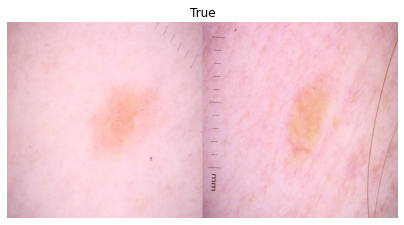

In [8]:
class SiameseImage(Tuple):
    def show(self, ctx=None, **kwargs):
        im1, im2, is_same = self
        return show_image(torch.cat([im1,im2], dim=2), title=is_same, ctx=ctx, **kwargs)
    

SiameseImage(img1, img2, True).show(figsize=(7,7));

# Siamese Dataset
For the **training** set, we will go through all our training filenames for the first image, then pick randomly:

- a filename of the same class for the second image (with probability 0.5)
- a filename of a different class for the second image (with probability 0.5)

For the **validation** set however, we will fix that random draw once and for all (otherwise we will validate on a different dataset at each epoch).

In [9]:
class SiameseTransform(Transform):
    def __init__(self, files, labels, is_valid=False):
        self.files     = files
        self.labels    = labels
        self.is_valid  = is_valid
        self.label_set = list(set(labels))
        self.lbl2files = {l: [f for (f,l2) in zip(files,labels) if l==l2] for l in self.label_set}
        self.vocab     = [[0,1]]#L(0,1)
        if is_valid:
            self.files2 = [self._find_second(l) for l in labels]
        
    def encodes(self, i):
        file1  = self.files[i]
        label1 = self.labels[i]
        
        (file2,same) = self.files2[i] if self.is_valid else self._find_second(label1)
        
        img1,img2 = open_image(file1,sz=SZ), open_image(file2,sz=SZ)
        return SiameseImage(TensorImage(img1), TensorImage(img2), torch.LongTensor([same]).squeeze())
        #return (TensorImage(img1), TensorImage(img2), torch.LongTensor([same]).squeeze())
        #return SiameseImage(TensorImage(img1), TensorImage(img2), TensorCategory(same))
    
    def _find_second(self, label1):
        same = random.random() < 0.5
        
        if same: label2 = label1
        else:    label2 = random.choice([l for l in self.label_set if l != label1])
            
        return random.choice(self.lbl2files[label2]), same

In [10]:
train_idxs, valid_idxs = TrainTestSplitter(test_size=VAL_PERC, random_state=42, stratify=df['target'])(df)

train_ds = TfmdLists(range(len(train_idxs)), SiameseTransform(files[train_idxs], labels[train_idxs]) )
valid_ds = TfmdLists(range(len(valid_idxs)), SiameseTransform(files[valid_idxs], labels[valid_idxs], is_valid=True))

In [11]:
#tfms = [[PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()],
#        [labeller, Categorize()]]
#dsets = Datasets(items, tfms)

In [12]:
train_ds.vocab

[[0, 1]]

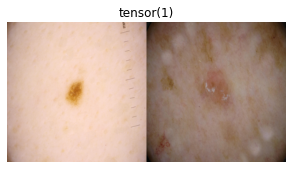

In [13]:
show_at(train_ds, 0);

In [14]:
train_ds[0]

(TensorImage([[[0.4314, 0.4431, 0.4706,  ..., 0.6588, 0.6392, 0.6196],
          [0.4353, 0.4627, 0.4941,  ..., 0.6627, 0.6471, 0.6353],
          [0.4510, 0.4784, 0.5020,  ..., 0.6667, 0.6588, 0.6431],
          ...,
          [0.4627, 0.4863, 0.4941,  ..., 0.6941, 0.6902, 0.6784],
          [0.4627, 0.4824, 0.4941,  ..., 0.6941, 0.6863, 0.6745],
          [0.4549, 0.4745, 0.4824,  ..., 0.6941, 0.6745, 0.6588]],
 
         [[0.2980, 0.3059, 0.3333,  ..., 0.5255, 0.5059, 0.4824],
          [0.2980, 0.3255, 0.3608,  ..., 0.5333, 0.5098, 0.4941],
          [0.3137, 0.3412, 0.3647,  ..., 0.5373, 0.5294, 0.5059],
          ...,
          [0.3216, 0.3451, 0.3529,  ..., 0.5725, 0.5647, 0.5490],
          [0.3176, 0.3373, 0.3529,  ..., 0.5765, 0.5569, 0.5451],
          [0.3098, 0.3294, 0.3451,  ..., 0.5686, 0.5529, 0.5373]],
 
         [[0.2000, 0.2196, 0.2510,  ..., 0.4863, 0.4549, 0.4078],
          [0.2078, 0.2471, 0.2784,  ..., 0.4941, 0.4588, 0.4353],
          [0.2353, 0.2627, 0.2863, 

In [15]:
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=BS,#, device="cuda", num_workers=4)#,
                             after_batch=[Normalize.from_stats(*imagenet_stats),
                                            *aug_transforms(flip_vert=True)])
dls = dls.cuda()

In [16]:
dls.vocab

[[0, 1]]

In [17]:
dls[0].vocab

[[0, 1]]

In [19]:
#dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
#                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [19]:
@typedispatch
def show_batch(x:SiameseImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=2, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs):
        SiameseImage(x[0][i], x[1][i], ['Different class','Same class'][x[2][i].item()]).show(ctx=ctx)
        #SiameseImage(x[0][i], x[1][i], ['Different class','Same class'][x[2][i].int().item()]).show(ctx=ctx)
        #SiameseImage(x[0][i], x[1][i], x[2][i].item()).show(ctx=ctx)

In [18]:
#dls.one_batch()

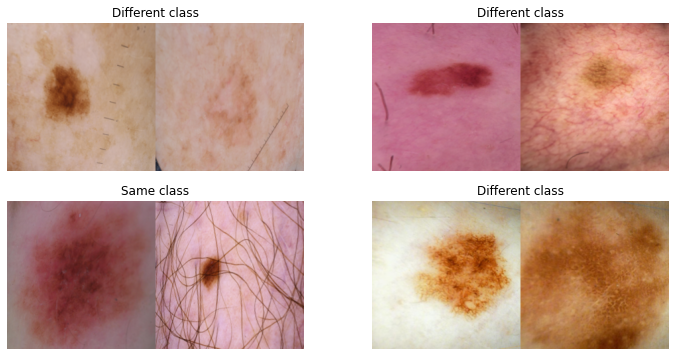

In [20]:
dls.show_batch(max_n=4, figsize=(12,6))

# Model

In [21]:
class SiameseModel(Module):
    def __init__(self, encoder, head):
        self.encoder,self.head = encoder,head
    
    def forward(self, x1, x2):
        ftrs = torch.cat([self.encoder(x1), self.encoder(x2)], dim=1)
        return self.head(ftrs)

In [22]:
model_meta[resnet34]

{'cut': -2,
 'split': <function fastai2.vision.learner._resnet_split(m)>,
 'stats': ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])}

### Head
`512*4`: Body ends up with 512 features, so for our custom head, we will need to multiply this by 4 (i.e. 2*2): 2 because we have two images concatenated, and another 2 because of the fastai concat-pool trick.

`2`: We also need to define the number of outputs of our head n_out, in our case it's 2: One for predicting both images are from the same class, and the other, to predict the contrary.

`ps=0.5`: is a list of probabiliies used for the dropouts 

In [23]:
body = create_body(resnet34, cut=-2)
head = create_head(512*4, 2, ps=0.5)
model = SiameseModel(body, head)

In [24]:
next(model.parameters()).device

device(type='cpu')

In [25]:
torch.cuda.is_available()

True

In [26]:
model = model.cuda()
next(model.parameters()).device

device(type='cuda', index=0)

# Learner

In [27]:
#def loss_func(out, targ):
#    return CrossEntropyLossFlat()(out, targ.long())

def model_frozen_splitter(model):
    return [params(model.encoder), params(model.head)]

learn = Learner(dls,#.cuda(),
                model,#.cuda(),
                loss_func=CrossEntropyLossFlat(),
                splitter=model_frozen_splitter,
                metrics=[accuracy,RocAuc()],
                cbs = ShowGraphCallback())

In [29]:
learn.freeze()

In [42]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.808619,0.765420,0.465812,0.466606,01:07
1,0.793122,0.711781,0.551282,0.552539,01:03
2,0.809146,0.745327,0.491453,0.492547,01:04


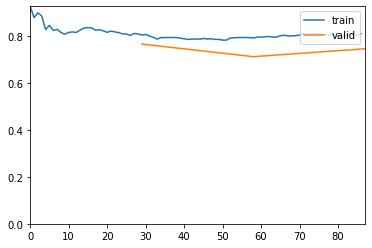

In [30]:
learn.fit_one_cycle(3, 1e-4)

In [ ]:
#learn.save('xresnet18_stg1')

In [31]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.805029,0.731678,0.525641,0.526160,01:09
1,0.829224,0.721691,0.512821,0.513263,01:07
2,0.844839,0.738401,0.534188,0.535733,01:06


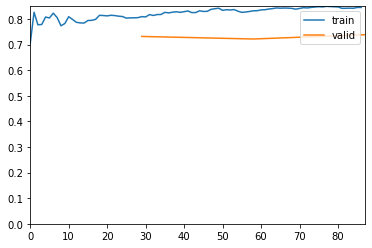

In [32]:
#learn.fit_flat_cos(3, slice(1e-6,1e-4))
learn.fit_one_cycle(3, 1e-4)

In [ ]:
#learn.save('xresnet18_stg2')

In [30]:
L(0,1)

(#2) [0,1]

# Interpret

In [30]:
#%debug ClassificationInterpretation.from_learner(learn)

In [33]:
interp = ClassificationInterpretation.from_learner(learn)

In [34]:
interp.vocab

[0, 1]

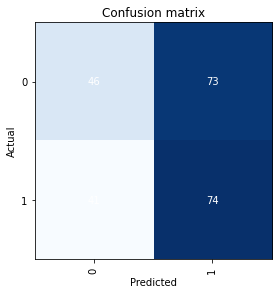

In [35]:
interp.plot_confusion_matrix()

In [34]:
interp.most_confused()

[(0, 1, 104)]

In [36]:
interp.print_classification_report()

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: object of type 'int' has no len()

In [34]:
SiamesePair

NameError: name 'SiamesePair' is not defined

In [35]:
#learn.predict(fnames[0])
#learn.show_results()

In [ ]:
Interpretation.from_learner(learn)

In [31]:
interp = Interpretation.from_learner(learn)

In [33]:
interp.plot_top_losses(12)

In [44]:
learn.dl.vocab = [0,1]

In [46]:
is_listy??

In [45]:
is_listy(dls.vocab)

True

In [32]:
len(dls.vocab)

2

In [43]:
learn.dls[1].one_batch()

(TensorImage([[[[-5.4048e-03, -4.5138e-02, -8.8973e-02,  ..., -3.6453e-01,
            -3.9018e-01, -5.0398e-01],
           [-1.2227e-02, -3.6189e-02, -9.3916e-02,  ..., -3.0650e-01,
            -3.4601e-01, -4.5268e-01],
           [ 1.3113e-02, -2.5739e-02, -1.0186e-01,  ..., -2.6762e-01,
            -3.0180e-01, -3.7089e-01],
           ...,
           [ 4.5933e-01,  4.8148e-01,  4.9263e-01,  ...,  4.8246e-01,
             4.5971e-01,  4.2447e-01],
           [ 4.6608e-01,  4.8678e-01,  4.9152e-01,  ...,  4.4708e-01,
             4.2330e-01,  3.9776e-01],
           [ 4.6565e-01,  4.7577e-01,  4.8216e-01,  ...,  4.1446e-01,
             3.7918e-01,  3.6376e-01]],
 
          [[-2.5775e-01, -3.2307e-01, -3.4941e-01,  ..., -8.0594e-01,
            -8.4535e-01, -9.0519e-01],
           [-2.5734e-01, -2.8900e-01, -3.1563e-01,  ..., -7.6588e-01,
            -8.0474e-01, -8.7600e-01],
           [-2.4696e-01, -2.6646e-01, -3.3098e-01,  ..., -7.3854e-01,
            -7.7431e-01, -8.1008e-

In [37]:
interp.plot_confusion_matrix??

# Test set

In [ ]:
#tst = source/'test'
#test_set = get_dicom_files(tst)
#test_set